# Seminar Notebook 2.1: Making a DFM

**LSE MY459: Computational Text Analysis and Large Language Models** (WT 2026)

**Ryan Hübert**

This notebook covers creating a DFM using a corpus of news articles.

## Directory management

We begin with some directory management to specify the file path to the folder on your computer where you wish to store data for this notebook.

In [23]:
import os
sdir = os.path.join(os.path.expanduser("~"), "LSE-MY459-WT26", "SeminarWeek04") # or whatever path you want
if not os.path.exists(sdir):
    os.mkdir(sdir)

We will begin by loading a corpus of news articles published in the Guardian during 2016. This corpus was sourced from the `{quanteda}` R package, see: <https://tutorials.quanteda.io/machine-learning/topicmodel/>. You can get a `.csv` version of the file from the `data` repo in the course GitHub. The following code chunk will download this file.

In [24]:
# Where is the remote file?
rfile = "https://raw.githubusercontent.com/lse-my459/data/master/corpus_guardian_2016.csv"

# Where will we store the local copy of it?
lfile = os.path.join(sdir, os.path.basename(rfile))

# Check if you have the file yet and if not, download it to correct location
if not os.path.exists(lfile):
    import requests         # only import module if needed
    r = requests.get(rfile) # make GET request for the remote file
    r.raise_for_status()    # raise exception if there's an HTTP error
    # Write the raw bytes received from the server to the local file path
    with open(lfile, "wb") as f:
        f.write(r.content)

### Loading and preprocessing the corpus

In the next cell, we load and clean the corpus.

In [25]:
import pandas as pd

tf = pd.read_csv(lfile, dtype="object")
tf["tid"] = tf["tid"].astype(int)
tf["datetime"] = pd.to_datetime((tf["date"] + " " + tf["edition"].str.replace(" GMT", "")), errors="coerce")
tf = tf.loc[:, ["tid", "pub", "datetime", "head", "texts"]]
tf = tf.sort_values("datetime")
tf.index = tf["tid"]
tf = tf.drop("tid", axis=1)

C:\Users\shuyi\AppData\Local\Temp\ipykernel_24784\1127922577.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  tf["datetime"] = pd.to_datetime((tf["date"] + " " + tf["edition"].str.replace(" GMT", "")), errors="coerce")


Next, we will work through standard pre-processing steps. Keep in mind that we are looking at a corpus of news articles, and that may affect how we pre-process. Let's start by tokenising on white space.

In [26]:
tf["preprocessed"] = tf["texts"].str.split(r"\s+")
tf.loc[:,["texts", "preprocessed"]].head()

,texts,preprocessed
tid,,
123947,A second man has died as a result of heavy flo...,"[A, second, man, has, died, as, a, result, of,..."
123945,As tensions continue in Chicago over the handl...,"[As, tensions, continue, in, Chicago, over, th..."
123932,Academic journals have begun withholding the g...,"[Academic, journals, have, begun, withholding,..."
125687,The brutal propaganda video released by Islami...,"[The, brutal, propaganda, video, released, by,..."
125661,A cache of 13 weapons has been discovered in t...,"[A, cache, of, 13, weapons, has, been, discove..."


Next, we make all words lowercase.

In [27]:
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [x.lower() for x in doc_tokens])
tf.loc[:,["texts", "preprocessed"]].head()

,texts,preprocessed
tid,,
123947,A second man has died as a result of heavy flo...,"[a, second, man, has, died, as, a, result, of,..."
123945,As tensions continue in Chicago over the handl...,"[as, tensions, continue, in, chicago, over, th..."
123932,Academic journals have begun withholding the g...,"[academic, journals, have, begun, withholding,..."
125687,The brutal propaganda video released by Islami...,"[the, brutal, propaganda, video, released, by,..."
125661,A cache of 13 weapons has been discovered in t...,"[a, cache, of, 13, weapons, has, been, discove..."


Next, we will clean up the text by removing extraneous punctuation, and dropping tokens we don't want. There is a lot of possible analyst discretion about how to do this.

In [28]:
import re

# Replace brackets
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [re.sub(r"(^[\[\(\{]|[\]\)\}]$)","", x) for x in doc_tokens])
# Keep only tokens that begin with a letter
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [x for x in doc_tokens if re.search(r"^[A-Za-z]", x)])
# Keep only tokens that have no numbers in them
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [x for x in doc_tokens if not re.search(r"[0-9]", x)])
# Remove all other punctuation, except dashes and apostrophes
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [re.sub(r'[^A-Za-z\-\']', '', x) for x in doc_tokens])
# Drop strings with article publishing time info
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [x for x in doc_tokens if not re.search(r"^(.*\-time|updated\-.*|gmt|bst)$", x)])
# Drop empty strings
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [x for x in doc_tokens if x != ""])
tf.loc[:,["texts", "preprocessed"]].head()

,texts,preprocessed
tid,,
123947,A second man has died as a result of heavy flo...,"[a, second, man, has, died, as, a, result, of,..."
123945,As tensions continue in Chicago over the handl...,"[as, tensions, continue, in, chicago, over, th..."
123932,Academic journals have begun withholding the g...,"[academic, journals, have, begun, withholding,..."
125687,The brutal propaganda video released by Islami...,"[the, brutal, propaganda, video, released, by,..."
125661,A cache of 13 weapons has been discovered in t...,"[a, cache, of, weapons, has, been, discovered,..."


We will remove English stop words from this corpus.

In [29]:
from nltk.corpus import stopwords
sw = [x.lower() for x in stopwords.words('english')]
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [x for x in doc_tokens if not x in sw])
tf.loc[:,["texts", "preprocessed"]].head()

,texts,preprocessed
tid,,
123947,A second man has died as a result of heavy flo...,"[second, man, died, result, heavy, flooding, s..."
123945,As tensions continue in Chicago over the handl...,"[tensions, continue, chicago, handling, police..."
123932,Academic journals have begun withholding the g...,"[academic, journals, begun, withholding, geogr..."
125687,The brutal propaganda video released by Islami...,"[brutal, propaganda, video, released, islamic,..."
125661,A cache of 13 weapons has been discovered in t...,"[cache, weapons, discovered, possession, gunma..."


Then, we will use the Snowball stemmer to create equivalence classes of tokens.

In [30]:
from nltk.stem import snowball
sstemmer = snowball.SnowballStemmer("english")
tf["preprocessed"] = tf["preprocessed"].apply(lambda doc_tokens: [sstemmer.stem(x) for x in doc_tokens])
tf.loc[:,["texts", "preprocessed"]].head()

,texts,preprocessed
tid,,
123947,A second man has died as a result of heavy flo...,"[second, man, die, result, heavi, flood, scotl..."
123945,As tensions continue in Chicago over the handl...,"[tension, continu, chicago, handl, polic, shoo..."
123932,Academic journals have begun withholding the g...,"[academ, journal, begun, withhold, geograph, l..."
125687,The brutal propaganda video released by Islami...,"[brutal, propaganda, video, releas, islam, sta..."
125661,A cache of 13 weapons has been discovered in t...,"[cach, weapon, discov, possess, gunman, open, ..."


Finally, can apply a `Counter` to the preprocessed tokens in `tf` to get token counts. 

In [31]:
from collections import Counter

tf["term_freqs"] = tf["preprocessed"].map(Counter)
tf.loc[:,["texts", "preprocessed", "term_freqs"]].head()

,texts,preprocessed,term_freqs
tid,,,
123947,A second man has died as a result of heavy flo...,"[second, man, die, result, heavi, flood, scotl...","{'second': 1, 'man': 5, 'die': 2, 'result': 1,..."
123945,As tensions continue in Chicago over the handl...,"[tension, continu, chicago, handl, polic, shoo...","{'tension': 1, 'continu': 1, 'chicago': 7, 'ha..."
123932,Academic journals have begun withholding the g...,"[academ, journal, begun, withhold, geograph, l...","{'academ': 2, 'journal': 4, 'begun': 1, 'withh..."
125687,The brutal propaganda video released by Islami...,"[brutal, propaganda, video, releas, islam, sta...","{'brutal': 1, 'propaganda': 7, 'video': 13, 'r..."
125661,A cache of 13 weapons has been discovered in t...,"[cach, weapon, discov, possess, gunman, open, ...","{'cach': 1, 'weapon': 4, 'discov': 1, 'possess..."


### Creating a document feature matrix (DFM)

We will now create a document feature matrix (DFM). We will use tools in `sklearn` to create a DFM in a sparse matrix format.

In [32]:
from sklearn.feature_extraction import DictVectorizer

# Step 1: initialise a DictVectorizer object, which we'll call `dv`
dv = DictVectorizer()

# Step 2: create the array from our data
dfm = dv.fit_transform(tf["term_freqs"].to_list())

# Check the shape is correct before continuing
dfm.shape 

(1959, 34241)

We will also be sure to extract and preserve the vocabulary from the `DictVectorizer` object.

In [33]:
# Step 3: be sure to keep the vocabulary for future reference
vocabulary = dv.get_feature_names_out()
vocabulary

array(['a-', 'a-level', 'a-list', ..., 'zyci', 'zylinskagoldsmith', 'zzz'],
      shape=(34241,), dtype=object)

### Trimming the DFM

Notice that the DFM has over 34,000 features. This is a _very_ sparse DFM. We will want to reduce its size by "trimming" it to remove features (i.e., weight them by zero). We will use the recommendation in [this tutorial](https://tutorials.quanteda.io/machine-learning/topicmodel/) and only keep features that are both (1) in the top 20% of total term frequency, and (2) used in no more than 10% of documents. Note that we are trimming the DFM using a similar intuition as tf-idf weighting.

In [34]:
import numpy as np

## Calculate TTF for each feature
ttf = dfm.sum(axis = 0).A1
## Calculate DF for each feature
docf = (dfm > 0).sum(axis=0).A1
## Define our cutoffs 
ttf_cutoff = np.quantile(ttf, 0.80)
docf_cutoff = dfm.shape[0] * 0.1
## Trim the DFM
dfm = dfm[:, (ttf >= ttf_cutoff) & (docf <= docf_cutoff)]
dfm.shape

(1959, 6236)

Warning: while we have trimmed the DFM, we have _not_ yet trimmed the corresponding `vocabulary` object, which we do next.

In [35]:
vocabulary = vocabulary[(ttf >= ttf_cutoff) & (docf <= docf_cutoff)]
vocabulary

array(['aamann', 'aaron', 'ab', ..., 'zuckerberg', 'zuma', 'zurawski'],
      shape=(6236,), dtype=object)

Let's quickly look at the top 20 features in this DFM to get a sense of how words are used in this corpus.

In [36]:
top_features = dfm.sum(axis = 0).A1
top_features = pd.Series(top_features, index=vocabulary)
top_features = top_features.astype(int)
top_features = top_features.sort_values(ascending=False)
top_features[0:20]

clinton       1895
sander        1222
cruz          1079
obama          848
refuge         718
photograph     672
gun            632
oil            625
hillari        612
australian     597
violenc        567
labor          563
corbyn         533
immigr         522
china          515
protest        509
water          503
rubio          498
game           492
johnson        490
dtype: int64

Now, let's create a wordcloud object.

In [37]:
import wordcloud

# Initialise the wordcloud object as `wc`
wc = wordcloud.WordCloud(width=800,
                         height=400,
                         background_color="white",
                         relative_scaling = 1,
                         max_words=200, 
                         random_state=42)

# Feed in the data from our `top_features` object
wc = wc.generate_from_frequencies(top_features)

# Don't use the default colours, and make blue
wc = wc.recolor(color_func=lambda *args, **kwargs: (51,51,255))

Finally, we'll plot the wordcloud object using `matplotlib`.

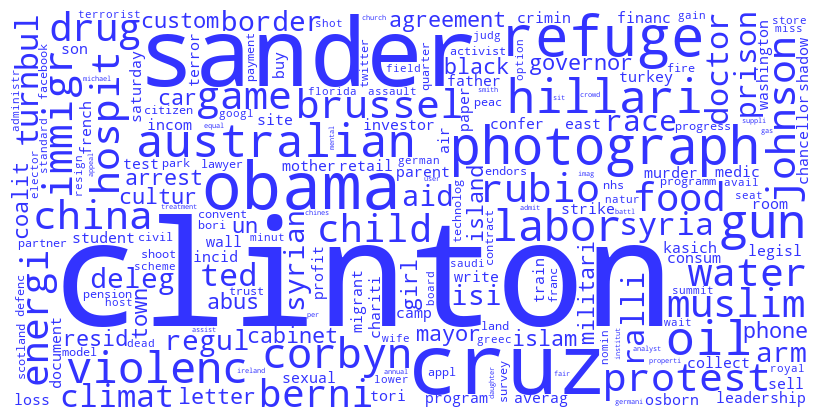

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.imshow(wc)
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

Now that we've created this DFM, let's save it for further use. We'll also save the corpus file as well, so that we can access the texts if/when needed!

In [39]:
from scipy import sparse

sparse_dfm_file = os.path.join(sdir, 'guardian-dfm.npz')
sparse.save_npz(sparse_dfm_file, dfm)

features_file = os.path.join(sdir, 'guardian-dfm-features.txt')
with open(features_file, 'w') as f:
    f.write("\n".join(vocabulary))

corpus_file = os.path.join(sdir, 'guardian-corpus.csv')
tf.iloc[:,0:4].to_csv(corpus_file)